In [ ]:
# docker run -p 8888:8888 -p 4040:4040 -v "%cd%:/home/jovyan/work" quay.io/jupyter/pyspark-notebook

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as F

from pyspark.sql.functions import col, sin, cos, lit
import math

import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("SeriesTemporales").getOrCreate()
# Leer archivo Parquet
df = spark.read.parquet("../../../data/transformed/madrid_data/parquet/")
df = df.orderBy(["fecha", "hora"])
# Mostrar datos
df.groupBy("anho").count().show()

+----+-----+
|anho|count|
+----+-----+
|2023| 8760|
|2022| 8760|
|2020| 8784|
|2021| 8760|
|2019| 8760|
|2024| 8784|
|2025| 1393|
+----+-----+



In [3]:
# Definir ventana para obtener las 3 horas anteriores
window_lag = Window.partitionBy("indicativo", "anho", "mes", "dia").orderBy("hora")

# Agregar columnas de las 3 horas previas
df = df.withColumn("temp_hora_1", F.lag("temperatura_media", 1).over(window_lag)) \
       .withColumn("temp_hora_2", F.lag("temperatura_media", 2).over(window_lag)) \
       .withColumn("temp_hora_3", F.lag("temperatura_media", 3).over(window_lag))

In [4]:
# Calcular temperatura general por hora, día y mes en todo el DataFrame
df_temp_stats = df.groupBy("hora", "dia", "mes").agg(
    F.avg("temperatura_media").alias("temp_media_general"),
    F.min("temperatura_media").alias("temp_min_general"),
    F.max("temperatura_media").alias("temp_max_general")
)
# Unir las estadísticas generales al DataFrame original
df = df.join(df_temp_stats, on=["hora", "dia", "mes"], how="left")

In [5]:
df = df.filter(df["anho"] >= 2023)
df.show(20, truncate=False)

+----+---+---+----------+-------------+-----------------+----------+----+-----------+-----------+-----------+------------------+----------------+----------------+
|hora|dia|mes|fecha     |humedad_media|temperatura_media|indicativo|anho|temp_hora_1|temp_hora_2|temp_hora_3|temp_media_general|temp_min_general|temp_max_general|
+----+---+---+----------+-------------+-----------------+----------+----+-----------+-----------+-----------+------------------+----------------+----------------+
|0   |1  |1  |2023-01-01|72.0         |3.4              |102       |2023|NULL       |NULL       |NULL       |3.4285714285714284|0.6             |6.9             |
|1   |1  |1  |2023-01-01|72.0         |3.0              |102       |2023|3.4        |NULL       |NULL       |3.0               |0.6             |6.3             |
|10  |1  |1  |2023-01-01|60.7         |4.0              |102       |2023|3.0        |3.4        |NULL       |3.9857142857142853|1.9             |8.6             |
|11  |1  |1  |2023-01-

In [6]:
# Agregar columnas de seno y coseno
df = df.withColumn("hora_sin", sin(2 * math.pi * col("hora") / lit(24)))
df = df.withColumn("hora_cos", cos(2 * math.pi * col("hora") / lit(24)))
df = df.withColumn("dia_sin", sin(2 * math.pi * col("dia") / lit(7)))
df = df.withColumn("dia_cos", cos(2 * math.pi * col("dia") / lit(7)))
df = df.withColumn("mes_sin", sin(2 * math.pi * col("mes") / lit(12)))
df = df.withColumn("mes_cos", cos(2 * math.pi * col("mes") / lit(12)))

df = df.drop("hora", "dia", "mes", "humedad_media", "anho", "fecha")

In [7]:
df.show(20)

+-----------------+----------+-----------+-----------+-----------+------------------+----------------+----------------+--------------------+--------------------+------------------+------------------+-------------------+------------------+
|temperatura_media|indicativo|temp_hora_1|temp_hora_2|temp_hora_3|temp_media_general|temp_min_general|temp_max_general|            hora_sin|            hora_cos|           dia_sin|           dia_cos|            mes_sin|           mes_cos|
+-----------------+----------+-----------+-----------+-----------+------------------+----------------+----------------+--------------------+--------------------+------------------+------------------+-------------------+------------------+
|              3.4|       102|       NULL|       NULL|       NULL|3.4285714285714284|             0.6|             6.9|                 0.0|                 1.0|0.7818314824680298|0.6234898018587336|0.49999999999999994|0.8660254037844387|
|              3.0|       102|        3.4|  

In [8]:
df_pandas = df.toPandas()

In [9]:
def grid_search(y, X):
    # Definir los rangos de p, d, q para buscar
    p = range(0, 4)  # AR terms
    d = range(0, 2)  # Differencing
    q = range(0, 4)  # MA terms
    
    # Generar combinaciones de parámetros
    pdq_combinations = list(itertools.product(p, d, q))
    
    # Almacenar resultados
    best_aic = float("inf")
    best_order = None
    results = []
    
    for order in pdq_combinations:
        try:
            model = ARIMA(y, exog=X, order=order, trend=None)
            result = model.fit()
            aic = result.aic
            
            results.append((order, aic))
    
            if aic < best_aic:
                best_aic = aic
                best_order = order
    
            print(f"Probando orden {order} - AIC: {aic}")
    
        except Exception as e:
            print(f"Error con orden {order}: {e}")
    return results

In [10]:
def show_graphics(y, forecast):
    # Limitar los datos históricos a los últimos 24 puntos
    historical_data = y[-24:]
    
    # Limitar las predicciones a los primeros 24 puntos
    forecast_data = forecast[:24]
    
    # Graficar los datos históricos (últimos 24 puntos)
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(historical_data)), historical_data, label='Datos históricos', color='blue')
    
    # Graficar las predicciones (primeros 24 puntos)
    plt.plot(range(len(historical_data), len(historical_data) + len(forecast_data)), forecast_data, label='Pronóstico', color='red', linestyle='--')
    
    # Añadir etiquetas y título
    plt.title('Pronóstico con ARIMAX')
    plt.xlabel('Tiempo')
    plt.ylabel('Valor')
    
    # Mostrar leyenda
    plt.legend()
    
    # Mostrar gráfico
    plt.show()

In [11]:
# Variables exógenas
#exog_variables = ['temp_hora_1', 'temp_hora_2', 'temp_hora_3', 'temp_media_general', 'temp_min_general', 'temp_max_general']

exog_variables = ['hora_sin', 'hora_cos', 'dia_sin', 'dia_cos', 'mes_sin', 'mes_cos']
# Eliminar valores nulos o rellenar
df_temps = df_pandas.dropna(subset=exog_variables + ['temperatura_media'])
X = df_temps[exog_variables]
y = df_temps['temperatura_media']

# Asegurarse de que los datos sean numéricos
X = X.astype(float)
y = y.astype(float)

In [12]:
results = grid_search(y, X)
results = sorted(results, key=lambda x: x[1])
best_order, best_aic = results[0]

print(f"\nMejor orden encontrado (temps): {best_order} con AIC: {best_aic}")

Probando orden (0, 0, 0) - AIC: 104831.52265234421
Probando orden (0, 0, 1) - AIC: 88293.13411745694
Probando orden (0, 0, 2) - AIC: 82058.97222458191
Probando orden (0, 0, 3) - AIC: 75530.23333910086
Probando orden (0, 1, 0) - AIC: 69488.28639158039
Probando orden (0, 1, 1) - AIC: 68955.346084602
Probando orden (0, 1, 2) - AIC: 68923.14261640036
Probando orden (0, 1, 3) - AIC: 68913.37514220935
Probando orden (1, 0, 0) - AIC: 68863.62127518037
Probando orden (1, 0, 1) - AIC: 68554.1191563788


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Probando orden (1, 0, 2) - AIC: 68553.50631523218


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Probando orden (1, 0, 3) - AIC: 68555.1480881837
Probando orden (1, 1, 0) - AIC: 69005.24346249488
Probando orden (1, 1, 1) - AIC: 68479.33387258917
Probando orden (1, 1, 2) - AIC: 68694.20289172784
Probando orden (1, 1, 3) - AIC: 68695.07725112692
Probando orden (2, 0, 0) - AIC: 68567.30734595716


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Probando orden (2, 0, 1) - AIC: 68553.36388360077


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Probando orden (2, 0, 2) - AIC: 68318.44722147952
Probando orden (2, 0, 3) - AIC: 68292.4512029655
Probando orden (2, 1, 0) - AIC: 68945.79599711398


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Probando orden (2, 1, 1) - AIC: 68339.72295538087
Probando orden (2, 1, 2) - AIC: 68679.30932230788


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Probando orden (2, 1, 3) - AIC: 68364.59047716485
Probando orden (3, 0, 0) - AIC: 68552.45019049184


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Probando orden (3, 0, 1) - AIC: 68275.13519072055


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Probando orden (3, 0, 2) - AIC: 68025.30009951355


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Probando orden (3, 0, 3) - AIC: 67953.20535503066
Probando orden (3, 1, 0) - AIC: 68947.40954571834
Probando orden (3, 1, 1) - AIC: 68341.70594246555


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Probando orden (3, 1, 2) - AIC: 68638.6540129079


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Probando orden (3, 1, 3) - AIC: 67745.64886737682

Mejor orden encontrado (temps): (3, 1, 3) con AIC: 67745.64886737682


In [18]:
best_model = ARIMA(y, exog=X, order=best_order)
best_result = best_model.fit()

# Mostrar resumen del modelo
print(best_result.summary())
forecast = best_result.forecast(steps=48, exog=X.tail(48))

# Mostrar resultados
print(forecast)

/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:      temperatura_media   No. Observations:                18937
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -33859.824
Date:                Sun, 09 Mar 2025   AIC                          67745.649
Time:                        14:16:26   BIC                          67847.684
Sample:                             0   HQIC                         67779.120
                              - 18937                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hora_sin      -3.4000      0.013   -256.871      0.000      -3.426      -3.374
hora_cos      -0.3885      0.012    -32.244      0.000      -0.412      -0.365
dia_sin       -0.1985      0.024     -8.212      0.0

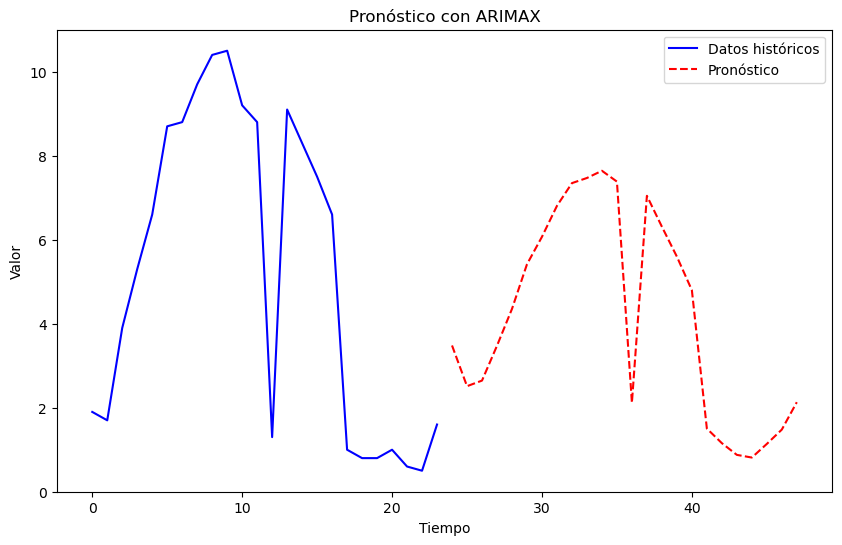

In [19]:
show_graphics(y, forecast)